In [1]:
%run ../../common/import_all.py

from common.setup_notebook import set_css_style, setup_matplotlib, config_ipython

import cv2

config_ipython()
setup_matplotlib()
set_css_style()

# Blurring, inverting, thresholding an image

## The original image

This is the original image we'll use here to demonstrate these manipulations. It's basically a photo I've taken of two pens on a red shiny desk, and the interesting thing is that shadow in the corner, due precisely to the surface being reflective.

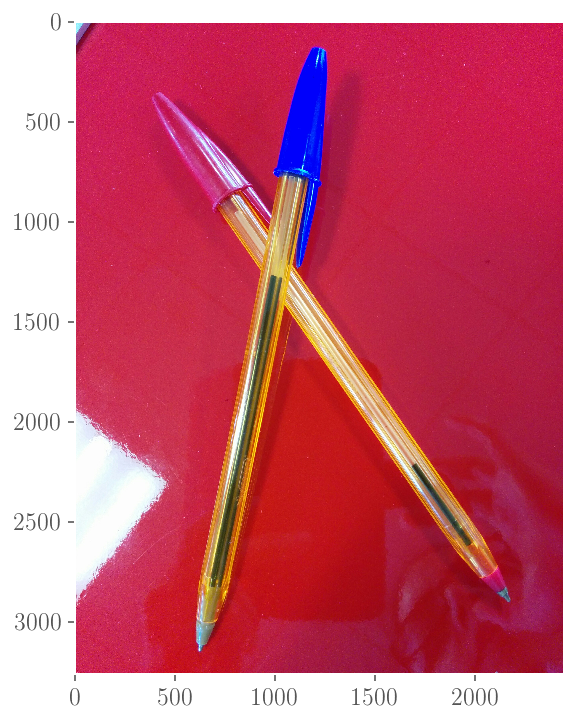

In [2]:
# read an image with OpenCV

image = cv2.imread('../../imgs/pens.jpg')

# transform into RGB as OpenCV reads in BGR (and Matplotlib uses RGB)
RGB_image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# show it
plt.imshow(RGB_image)
plt.grid()
plt.show();

## Blurring

*Blurring* is also called *smoothing* and it is an operation typically used to reduce noise on the source. It consists in applying a filter to the image. Let's see what this means.

The operation goes like this:

$$
g(i,j) = \sum_{h,l} f(i+h, j+l) K(h,l) \ ,
$$

where $g(i,j)$ represents the transformed value of the pixel at position $(i,j)$, $K(h,l)$ is the *kernel* and $f$ represents the original pixels. What the sum is doing is weighing every pixel by the kernel and considering its neighborhood. The kernel is a matrix which determines how should the neighborhood be factored in.


In the following, we'll go through some common types of filters and we'll try them out on a the image.

### Common types of filters and trying them out

#### Normalised Box Filter

Each pixel value gets transformed into the mean of its neighbours, each of which contributes with equal weight:. The kernel $K$ is a matrix with the same value at each place, and this value is

$$
k = \frac{1}{k_w k_h} \ ,
$$

where $k_w, k_h$ are the (width and height) dimensions of the matrix. In other words, this filter is considering a neighborhood rectangle of dimension $k_w \times k_h$ around each pixel and averaging the intensities values inside it, assigning to pixels.

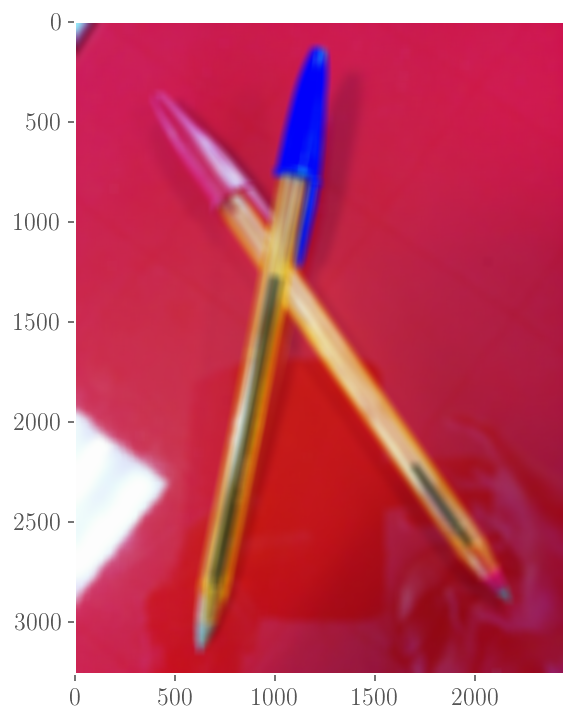

In [6]:
# a normalised box filter with kernel 50X50 and showing result
nb = cv2.blur(RGB_image, (50, 50))

plt.imshow(nb)
plt.grid()
plt.show();

#### Gaussian Filter

It's the most popular but not the fastest. The kernel is given by a gaussian in 2 dimensions, so that at a point $(x, y)$ it is:

$$
K(x, y) = \frac{1}{2 \pi \sigma_x \sigma_y} e^{-\frac{(x - \mu_x)^2}{2 \sigma_x^2}} e^{-\frac{(y - \mu_y)^2}{2 \sigma_y^2}} 
$$

This way, the pixel in the middle is given the largest weight and this weight decreases normally with distance to the pixel in consideration. Look at the [docs](http://docs.opencv.org/3.2.0/d4/d86/group__imgproc__filter.html#gaabe8c836e97159a9193fb0b11ac52cf1) for the implementation of this filter in OpenCV3. 

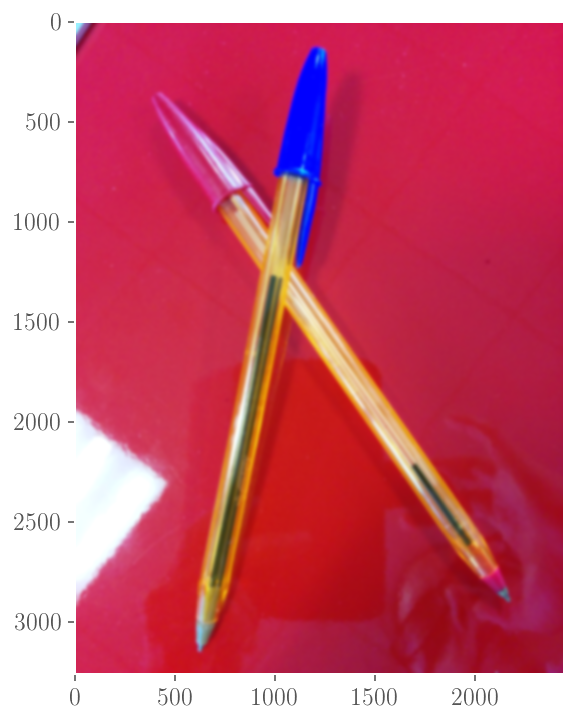

In [3]:
# a Gaussian filter with kernel 49X49 and  and showing result
# Note that the third (required) arg is the sigma_x, if 0 means both sigma_x and sigma_y are calculated from the
# kernel size. Also note kernel size must be odd (not sure why this constraint)
gb = cv2.GaussianBlur(RGB_image, (49, 49), 0)

plt.imshow(gb)
plt.grid()
plt.show();

#### Median Filter

Each pixel gets replaced with the median of its neighbours (those in a square around it).

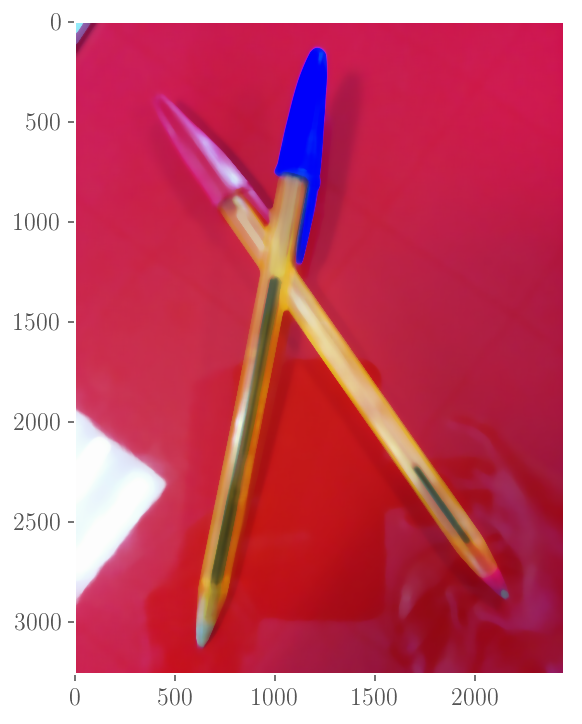

In [4]:
# a median filter with kernel 49X49 and  and showing result
# Note kernel size must be odd as for the gaussian (?)
mb = cv2.medianBlur(RGB_image, 49)

plt.imshow(mb)
plt.grid()
plt.show();

#### Bilateral Filter

Avoids (to a certain extent) smoothing the edges in a picture (all other filters don't avoid that). Considers neighbouring pixels with weight. In a region of pixels similar in intensity, it will replace pixel with the average of neighborhood, acting similarly to other filters; in a region where there is a boundary of two intensity areas, that is, a region where pixels on one side are sensibly brighter than those on the other side, a bilateral filter yields a value of $1$ for pixels on the same side and $0$ for the others. See [[1]](#bilateral) for a detailed explanation and the OpenCV3 [docs](http://docs.opencv.org/3.2.0/d4/d86/group__imgproc__filter.html#ga9d7064d478c95d60003cf839430737ed) for the API.

Note that it's a quite slow algorithm, especially for large diameters of the neighborhood.

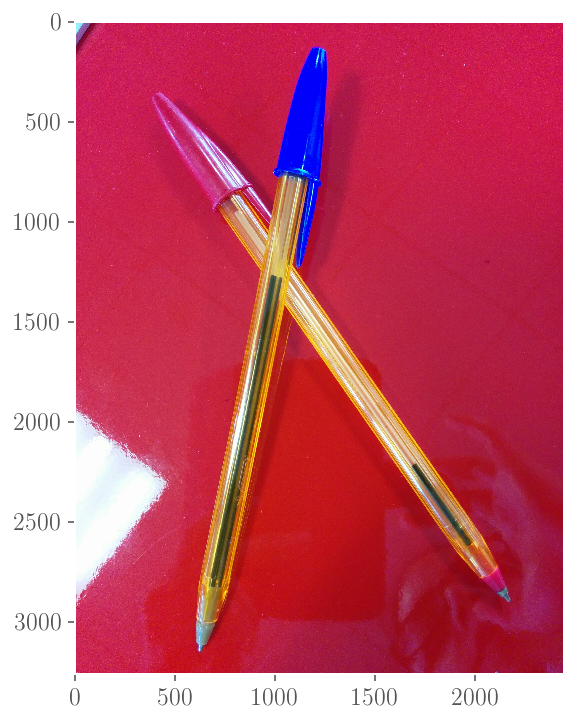

In [5]:
# a bilateral filter with kernel of diameter 15 and sigmas in color space and coordinate space
bb = cv2.bilateralFilter(RGB_image, 15, 2, 2)

plt.imshow(bb)
plt.grid()
plt.show();

## Inverting

Inverting an image means subtracting each pixel value from $255$, so that white becomes black and vice versa. 

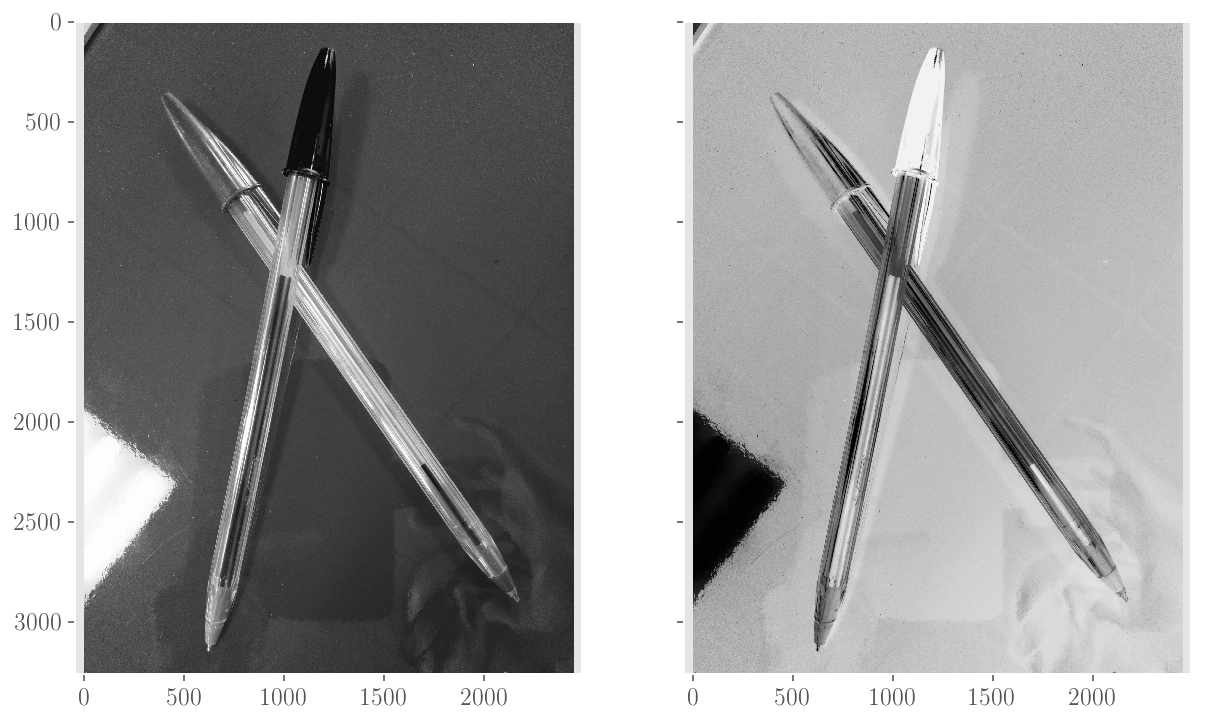

In [7]:
# make the sample image grayscale
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

# invert it
inverted = 255 - gray

# Plot both gray image and inverted

plt.gray()
f, (ax1, ax2) = plt.subplots(1, 2, sharey=True)

ax1.grid()
ax1.imshow(gray)

ax2.grid()
ax2.imshow(inverted)

plt.show();

## Thresholding

See the [API](http://docs.opencv.org/2.4/modules/imgproc/doc/miscellaneous_transformations.html?highlight=threshold#cv2.threshold) call `cv2.threshold` needs the gray image as first argument, the threshold $t$ as the second argument and the value to assign as the third argument in the case of a binary and binary inverted thresholding.

See [[2]] for an explanation of thresholding with graphics on OpenCV itself. 

Thresholding is a way to modify the pixels of an image based on a given threshold in their intensity/colour.

### Simple Thresholding

Applied to grayscale images, it sets the pixel to a new value if it exceeds a given threshold and to another value otherwise. Modes are, calling $p(x, y)$ the pixel, $a$ the value to set and $t$ the threshold:

* **binary**: 
$$
p'(x, y) = 
\begin{cases}
a \ \text{if} \ p(x,y) > t \\
0 \ \text{else}
\end{cases}
$$

* **binary inverted**: 
$$
p'(x, y) = 
\begin{cases}
0 \ \text{if} \ p(x,y) > t \\
a \ \text{else}
\end{cases}
$$

* **threshold truncated**: 
$$
p'(x, y) = 
\begin{cases}
t \ \text{if} \ p(x,y) > t \\
p(x,y) \ \text{else}
\end{cases}
$$

* **threshold to zero**: 
$$
p'(x, y) = 
\begin{cases}
p(x,y) \ \text{if} \ p(x,y) > t \\
0 \ \text{else}
\end{cases}
$$

* **threshold to zero inverted**:
$$
p'(x, y) = 
\begin{cases}
0 \ \text{if} \ p(x,y) > t \\
p(x,y) \ \text{else}
\end{cases}
$$

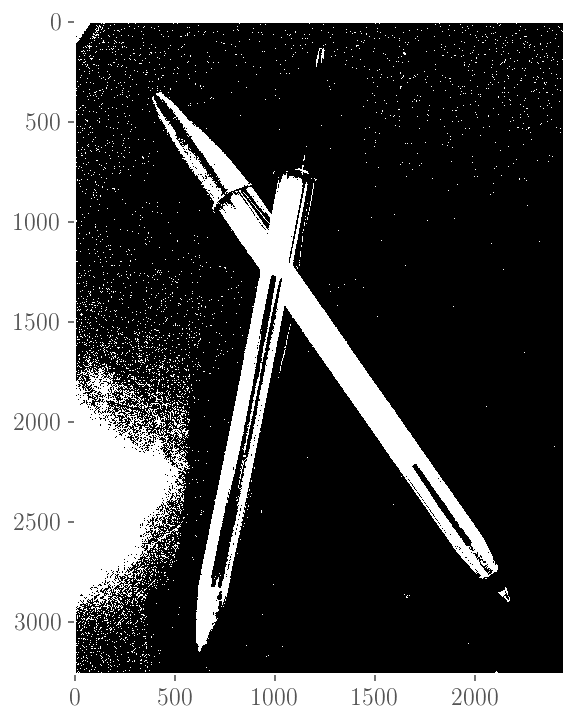

In [8]:
# binary threshold: put 255 (white) if pixel passes 100 threshold, 0 (black) otherwise

dest = cv2.threshold(gray, 100, 255, cv2.THRESH_BINARY)[1]

plt.gray()
plt.grid()
plt.imshow(dest)
plt.show();

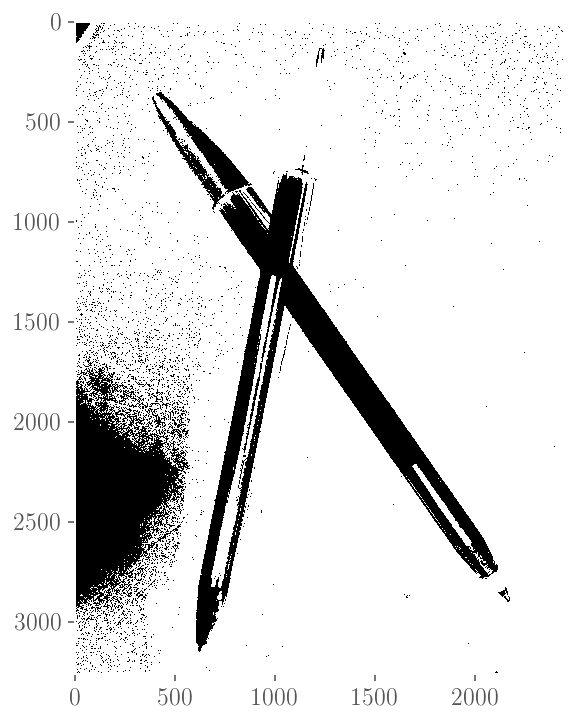

In [9]:
# binary inverted threshold: put 0 (black) if pixel passes 100 threshold, 255 (white) otherwise

dest = cv2.threshold(gray, 100, 255, cv2.THRESH_BINARY_INV)[1]

plt.gray()
plt.grid()
plt.imshow(dest)
plt.show();

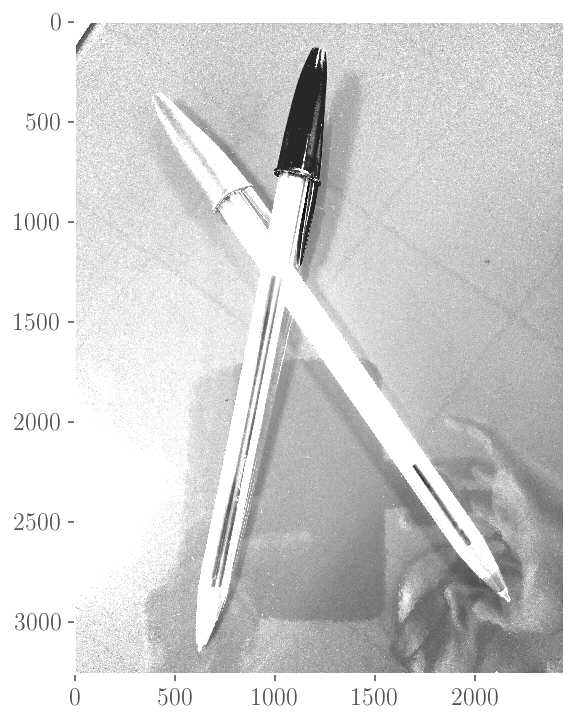

In [10]:
# binary truncated: put threshold value if pixel passes 100 threshold, keep pixel value otherwise

dest = cv2.threshold(gray, 100, 255, cv2.THRESH_TRUNC)[1]   # note 255 here is useless but needed by method

plt.gray()
plt.grid()
plt.imshow(dest)
plt.show();

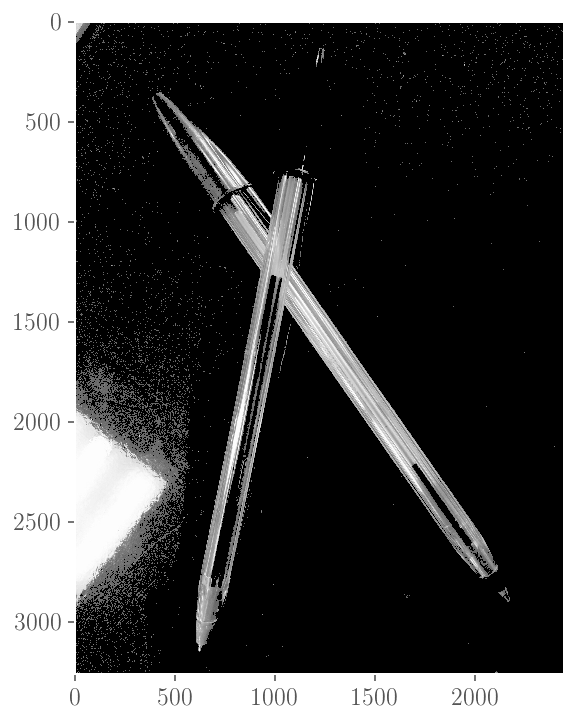

In [11]:
# to zero: put pixel value if pixel passes 100 threshold, 0 otherwise

dest = cv2.threshold(gray, 100, 255, cv2.THRESH_TOZERO)[1]   # note 255 here is useless but needed by method

plt.gray()
plt.grid()
plt.imshow(dest)
plt.show();

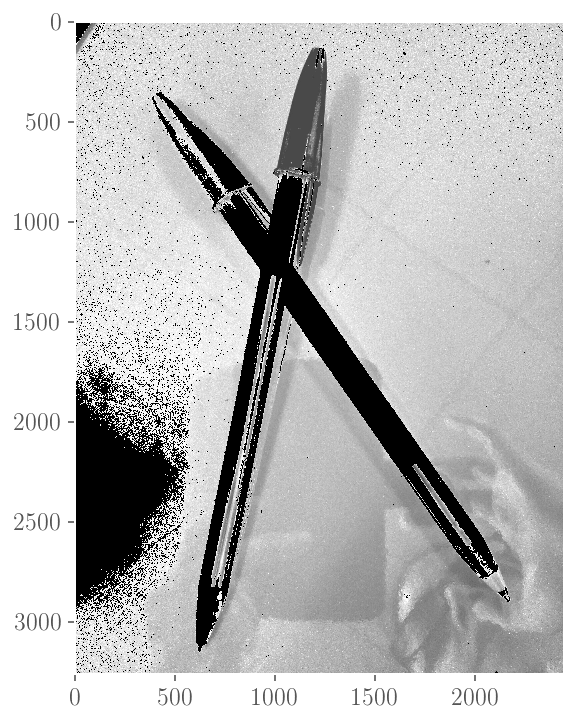

In [12]:
# to zero inverted: put 0 if pixel passes threshold, keep pixel value otherwise

dest = cv2.threshold(gray, 100, 255, cv2.THRESH_TOZERO_INV)[1]   # note 255 here is useless but needed by method

plt.gray()
plt.grid()
plt.imshow(dest)
plt.show();

### Adaptive Thresholding

Applied to grayscale images, the threshold is calculated locally so it is different for each region and this accounts for different conditions like illumination. Modes are *binary* and *binary inverted*, as above, with the difference that $t = t(x, y)$. The pixel gets set to a specified new value. Methods are:

* **Adaptive mean**: $t(x, y)$ is the average of the neighbourhood of pixel $p(x, y)$, the neighborhood being a square of specified size around pixel
* **Adaptive gaussian**: $t(x, y)$ is a weighted sum, with gaussian weights of the neighbourhood of pixel $p(x, y)$. The standard deviation depends on the block size. 

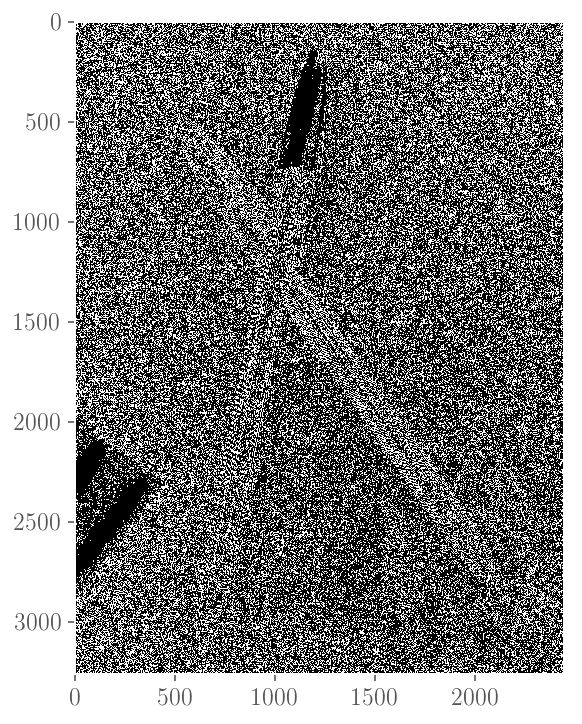

In [13]:
# adaptive mean thresholding with binary method and a neighborhood of 3X3
# note that last arg (required) gets subtracted from the mean for computing the threshold

dest = cv2.adaptiveThreshold(gray, 100, cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY, 3, 0)

plt.gray()
plt.grid()
plt.imshow(dest)
plt.show();

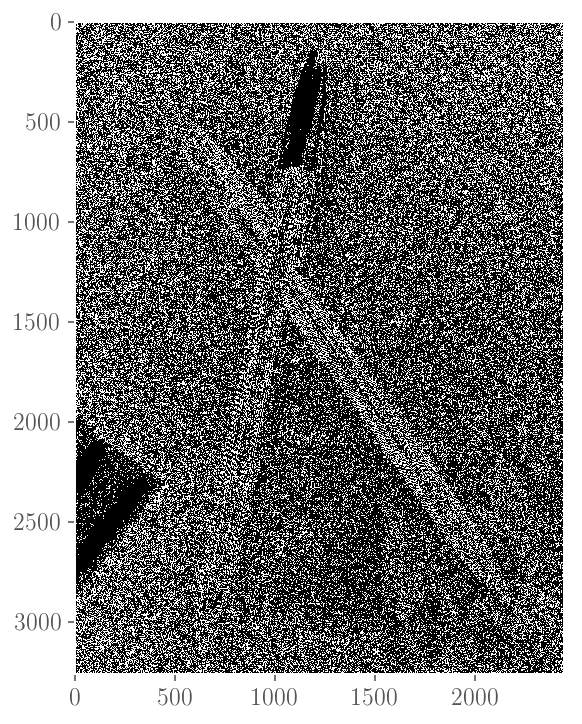

In [14]:
# adaptive gaussian thresholding with binary method and a neighborhood of 3X3
# note that last arg (required) gets subtracted from the mean for computing the threshold

dest = cv2.adaptiveThreshold(gray, 100, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 3, 0)

plt.gray()
plt.grid()
plt.imshow(dest)
plt.show();

### Otsu's Binarization Thresholding

This [[2]](#otsu) is a global thresholding method but the value of the threshold is computed as the mean value in between the two peaks of a [bimodal image](../some-glossary.ipynb#Bimodal-image). For this reason, it is not good on non-bimodal images. It minimises the weighted within-class variance where a class is the set of pixels around a peak. 

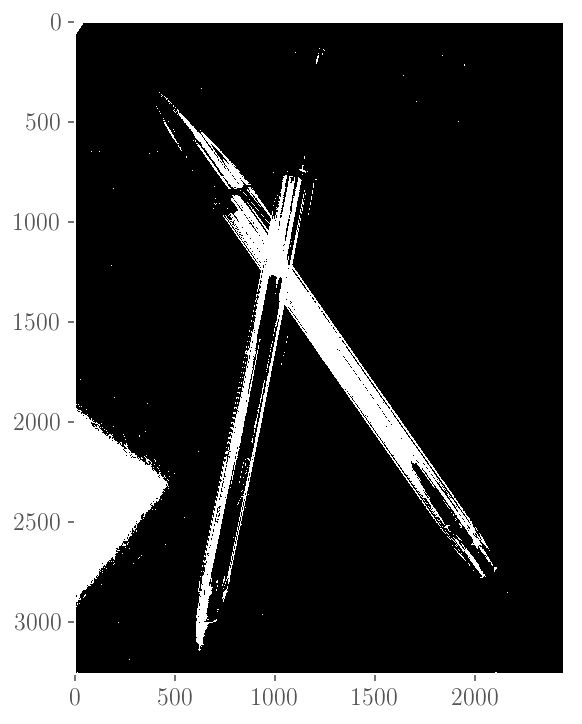

In [15]:
# Otsu binarisation

dest = cv2.threshold(gray, 100, 255, cv2.THRESH_OTSU)[1]

plt.gray()
plt.grid()
plt.imshow(dest)
plt.show();

## References

1. <a name="bilateral"></a> A detailed [explanation](http://homepages.inf.ed.ac.uk/rbf/CVonline/LOCAL_COPIES/MANDUCHI1/Bilateral_Filtering.html) of the bilateral filter
2. <a name="opencv"></a> The [explanation](http://docs.opencv.org/2.4/doc/tutorials/imgproc/threshold/threshold.html) of thresholding on OpenCV itself
3. <a  name="otsu"></a> N Otsu, [**A Threshold Selection Method from Gray-Level Histograms**](http://web-ext.u-aizu.ac.jp/course/bmclass/documents/otsu1979.pdf), *IEEE Transactions on Systems, Man and Cybernetics*, 9, 1979.